In [6]:
import math
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import datetime
from statsmodels import robust
import matplotlib as mpl
from matplotlib import gridspec
import pylab
from matplotlib import cm
from pytz import timezone
import Analysis
from scipy.stats import norm

A function to determine the values for each pixel in the image, and from there to determine the ideal threshohold value. To be automated after the code works for a sample of 6 images

Make it a gaussian and take where two standard deviations away would be
Also try finding where the slope goes from negative to positive

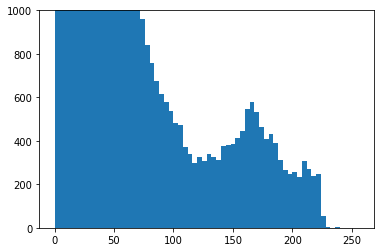

27883.558333333334

In [7]:
img = cv2.imread("20191026_052745_Snap.png",0)

plt.hist(img.ravel(),64,[0,256]); plt.ylim(0,1000); plt.show()

Sum = np.sum(img)

Length = len(img)

Sum/Length
#cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]) This is the raw function before values inputed

#cv2.calcHist([img], [0], None, [256], [0,256])

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

The threshold value of this image is: 38.727164351851854


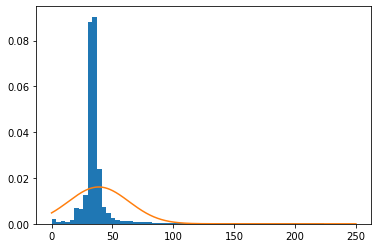

In [8]:
list = img.ravel()

def Gaussian(x,x0,sig):
    y= (1/(np.sqrt(2*np.pi)*sig))*np.exp(-(x-x0)**2/2/sig**2)
    return(y)
plt.hist(list,bins = 64,density=True)
xlist = np.arange(0,250,0.01)
ylist = Gaussian(xlist,np.mean(list),np.std(list))
plt.plot(xlist,ylist)
value = np.mean(list)#-(np.std(list))
print("The threshold value of this image is:",value)

In [4]:
Cloudmap = img
kernel = np.ones((1,1),np.uint8)


ret,threshCloud = cv2.threshold(Cloudmap,value*2,255,cv2.THRESH_BINARY_INV)
threshCloudOpen = cv2.morphologyEx(threshCloud, cv2.MORPH_OPEN, kernel)
threshCloudFinal = cv2.morphologyEx(threshCloudOpen, cv2.MORPH_CLOSE, kernel)
cv2.imshow("Threshcloud", threshCloudFinal)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:

# Load angdist/pixel document [ratio, xloc, yloc]
star_ratios = np.loadtxt('loc_and_ratios.txt')

# Find center of data
midpoint = (720/2,480/2)

# Loop of angles to rotate through
rads = np.arange(0,2*np.pi,np.deg2rad(5))

empty = []

for i in np.arange(0,len(rads)):
    # rotate original by ang radians
    ang = rads[i]
    
    # Make everything centered at (0,0)
    xs = star_ratios[:,1]-midpoint[0]
    ys = star_ratios[:,2]- midpoint[1]
    
    # Rotation matrix!
    rota = [[np.cos(ang), -np.sin(ang)],[np.sin(ang),np.cos(ang)]]
    mul = np.matmul(rota,[xs,ys])
    trans = np.transpose(mul)
    
    # Move things back to way they were
    xs2 = trans[:,0]+midpoint[0]
    ys2 = trans[:,1]+midpoint[1]
    
    # Append to array
    rotated_group = np.column_stack((star_ratios[:,0],xs2,ys2))
    if i == 0:
        all_rotated_copies = rotated_group
    else:
        all_rotated_copies = np.vstack((all_rotated_copies,rotated_group))

# Only care about data points that fall within our camera pixel regions

cond1 = (all_rotated_copies[:,1]>=0)&(all_rotated_copies[:,1]<=720)
cond2 = (all_rotated_copies[:,2]>=0)&(all_rotated_copies[:,2]<=480)
cond12 = cond1&cond2

# Here we make the different squares have different ratio values

# This inc can be changed to make squares different sized
inc = 40
xdivs = np.arange(0,720+inc,inc)
ydivs = np.arange(0,480+inc,inc)
ydivs = ydivs[::-1]

# Create empty array
empty = np.zeros((len(ydivs)-1,len(xdivs)-1))

# Look in each square region
for i in np.arange(0,len(xdivs)-1):
    left = xdivs[i]
    right = xdivs[i+1]
    for j in np.arange(0,len(ydivs)-1):
        bottom = ydivs[j+1]
        top = ydivs[j]
        
        # Look at all data points within x and y bounds
        cond_x = ((all_rotated_copies[:,1] >= left)&(all_rotated_copies[:,1] < right))
        cond_y = ((all_rotated_copies[:,2] >= bottom)&(all_rotated_copies[:,2] < top))
        cond_both = (cond_x&cond_y)
        subset = all_rotated_copies[cond_both]
        
        # If anything is in there, average the ratios and append to empty array
        if len(subset) > 0:
            empty[j,i] = np.average(subset[:,0])
        else:
            empty[j,i] = 0



In [10]:
cloudmapAnalysis = empty
NewCloudMapAnalysis = cv2.resize(cloudmapAnalysis,(720,480))
Final = NewCloudMapAnalysis*threshCloudFinal

In [17]:
cv2.imshow("Final", Final)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
cv2.imshow("Final", NewCloudMapAnalysis)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
cv2.imshow("Final", threshCloudFinal)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
np.sum(Final)

2207988.557828437

In [13]:
np.sum(threshCloudFinal)

15383130